In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ipywidgets as widgets
from IPython.display import display, clear_output

In [261]:
def load_dataset():
    """Extract data for books, ratings and users from csv files, join on ISBN and user ID"""
    books_path = "dataset/books.csv"
    users_path = "dataset/users.csv"
    ratings_path = "dataset/ratings.csv"

    # the .csv file isn't valid, books contain few records with more columns
    # we skip them for simplicity

    print("Loading books...")
    books_df = pd.read_csv(books_path, delimiter=";", on_bad_lines="warn")

    print("Loading users...")
    users_df = pd.read_csv(users_path, delimiter=";", on_bad_lines="warn")

    print("Loading ratings...")
    ratings_df = pd.read_csv(ratings_path, delimiter=";", on_bad_lines="warn")


    print(f"Books dataset rows: {len(books_df)}")
    print(f"Users dataset rows: {len(users_df)}")
    print(f"Ratings dataset rows: {len(ratings_df)}")

    return books_df, users_df, ratings_df

def merge_df(books_df, users_df, ratings_df, how="inner"):
    df: pd.DataFrame = pd.merge(users_df, ratings_df, on="user_id", how=how)
    df = pd.merge(df, books_df, on="ISBN", how=how)
    return df



books, users, ratings = load_dataset()


Loading books...


b'Skipping line 43667: expected 8 fields, saw 10\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 10\nSkipping line 261529: expected 8 fields, saw 9\n'
/tmp/ipykernel_12204/1178397520.py:33: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  books, users, ratings = load_dataset()
b'Skipping line 18758: expected 3 fields, saw 4\n'


Loading users...
Loading ratings...
Books dataset rows: 271373
Users dataset rows: 278856
Ratings dataset rows: 1149780


# Cleaning the data

## Users

In [262]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278856 entries, 0 to 278855
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278856 non-null  int64  
 1   location  278856 non-null  object 
 2   age       168094 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


### **Age**

<AxesSubplot:>

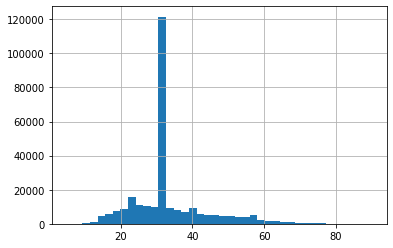

In [263]:
plt.figure()
users.loc[(users.age > 90) | (users.age < 5), 'age'] = np.nan
users.age = users.age.fillna(users.age.median()).astype(np.int32)
users.age.hist(bins=40)

# Lot of users are missing valid age

In [264]:
## TODO: location info is maybe too specific
users.location.unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

<AxesSubplot:xlabel='age'>

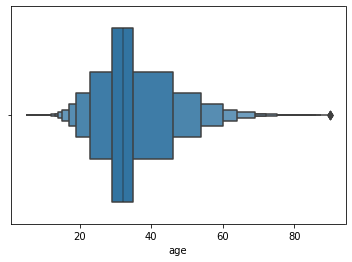

In [265]:
plt.figure()
sns.boxenplot(x=users.age)

In [266]:
# And maybe we also want user-id to be a int32
users.user_id = users.user_id.astype(np.int32)

### **Location**

In [267]:
loc_segments = pd.DataFrame(users.location.str.split(",", n=0, expand=True))

users["city"] = loc_segments[0].str.strip()
users["state"]= loc_segments[1].str.strip()
users["country"] = loc_segments[2].str.strip()

users.drop("location", inplace=True, axis=1)
users.head()

,user_id,age,city,state,country
0,1,32,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,32,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,32,farnborough,hants,united kingdom


#### **Cleaning missing values**

In [268]:
# Location field contains many mistakes, we fix some
users.loc[users.country.str.len() <= 1, ["country"]] = "n/a"
users.loc[users.state.str.len() <= 1, ["state"]] = "n/a"
users.loc[users.city.str.len() <= 1, ["city"]] = "n/a"

# users.loc[users.country.isnull(), ["country"]] = "n/a"
# users.loc[users.state.isnull(), ["state"]] = "n/a"
# users.loc[users.city.isnull(), ["city"]] = "n/a"

# We could also filter out non-frequent countries/states/cities


# users[["country", "state", "city"]].fillna("n/a")
# print(sum(users.country.isnull()))
# print(sum(users.state.isnull()))
# print(sum(users.city.isnull()))

# user_id and age has been handeled
# filling only location fields
users.fillna("n/a", inplace=True)
# users.isnull().sum()

## Books

In [269]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271373 entries, 0 to 271372
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271373 non-null  object
 1   book_title           271373 non-null  object
 2   book_author          271372 non-null  object
 3   year_of_publication  271373 non-null  object
 4   publisher            271371 non-null  object
 5   Image-URL-S          271373 non-null  object
 6   Image-URL-M          271373 non-null  object
 7   Image-URL-L          271370 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [270]:
# we can drop Image-URLs, because those won't be much helpful in making recommendation decisions
books.drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)


### **Year of publication**

In [271]:
books.year_of_publication.describe()

count     271373
unique       202
top         2002
freq       13901
Name: year_of_publication, dtype: int64

In [272]:
# we can see that some year are ints, some strings and there are even non-numeric values ("DK Publishing Inc", "Gallimard")
# there is also a '0' year value
books.year_of_publication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2002', '2000', '1996', '1992',
       '1999', '1995', '2004', '2003', '1990', '1994', '1986', '1989',
       '1981', '1993', '1983', '1982', '1976', '1991', '1977', '1998',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [273]:
books[books.year_of_publication == "DK Publishing Inc"]

,ISBN,book_title,book_author,year_of_publication,publisher
209546,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelb...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221687,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";Jam...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [274]:
books[books.year_of_publication == "Gallimard"]

,ISBN,book_title,book_author,year_of_publication,publisher
220740,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [275]:
# let's just drop those
books = books[books.year_of_publication != "DK Publishing Inc"]
books = books[books.year_of_publication != "Gallimard"]


# and unify the int and string representations
books.year_of_publication = pd.to_numeric(books.year_of_publication)


# replace the invalid years with a mean
# have to do this in 2 steps, such that the median isn't biased with the books with invalid publication years
books.loc[(books.year_of_publication > 2021) | (books.year_of_publication < 1500), "year_of_publication"] = np.nan
books.year_of_publication = books.year_of_publication.fillna(round(books.year_of_publication.median())).astype(np.int32)

/home/kubik/work/datasentics_task/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year_of_publication'>

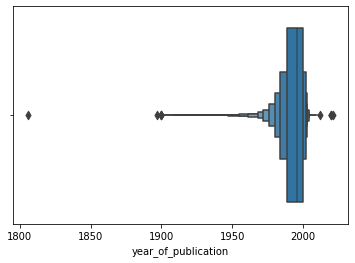

In [276]:
sns.boxenplot(books.year_of_publication)

### **Book duplicities**
Some book authors and publishers are NaN.

Numerical attribute year_of_publication has been dealt with, so we can replace all remaining nulls with "n/a"

In [277]:
books.fillna("n/a", inplace=True)

In case there are some capitalization inconsitencies in the data, convert every field to lowercase.

In [278]:
# we must not forget to convert the ratings ISBNs to lowercase as well!

print("Unique values in the original:")
print(books.nunique())
books.ISBN = books.ISBN.str.lower()
books.book_title = books.book_title.str.lower()
books.book_author = books.book_author.str.lower()
books.publisher = books.publisher.str.lower()

print("\nUnique values in the lowercased data:")
print(books.nunique())

Unique values in the original:
ISBN                   271370
book_title             242145
book_author            102027
year_of_publication       107
publisher               16806
dtype: int64

Unique values in the lowercased data:
ISBN                   271056
book_title             238974
book_author             99345
year_of_publication       107
publisher               16574
dtype: int64


There are over 300 books with duplicit ISBN, so let's drop those.

In [279]:
# Let's drop ISBN duplicities
books.drop_duplicates(["ISBN"], inplace=True)



But even then, huge number of book records share the same duplicit `(book_title, book_author)` pairs.

That is mainly because the same book can be re-published and repackaged multiple times with different ISBN under different publishers.

In [280]:
print("Number of duplicit (book_title, book_author) pairs:\n", len(books[books[["book_title", "book_author"]].duplicated()]))

Number of duplicit (book_title, book_author) pairs:
 22807


For example, **Angels & demons** by Dan Brown is present in 5 different versions.

In [281]:
books[(books.book_title == "angels & demons") & (books.book_author == "dan brown")]

,ISBN,book_title,book_author,year_of_publication,publisher
118,0671027360,angels & demons,dan brown,2001,pocket star
239,0743486226,angels & demons,dan brown,2003,atria
28003,0671027352,angels & demons,dan brown,2000,atria
36936,0743535774,angels & demons,dan brown,2003,audioworks
163548,0743535766,angels & demons,dan brown,2003,simon & schuster audio


Furthermore, there other types of duplicities.
For example, There are 9 unique `(book_title, book_author)` pairs for **The fellowship of the ring**. So even if we did drop duplicate `(book_title, book_author)` pairs, we wouldn't catch these.

In [282]:
books[books.book_title.str.contains("fellowship of the ring") & books.book_author.str.contains("tolkien")][["book_title", "book_author"]].drop_duplicates()

,book_title,book_author
1571,"the fellowship of the ring (the lord of the rings, part 1)",j.r.r. tolkien
4514,the fellowship of the ring (lord of the rings (paperback)),j. r. r. tolkien
6514,the fellowship of the ring,j. r. r. tolkien
12764,"the fellowship of the ring (the lord of the rings, part 1)",j. r. r. tolkien
55114,"the fellowship of the ring: 1st part: the lord of the rings (eflkien, j. r. r. lord of the rings...",j. r. r. tolkien
144281,the fellowship of the ring: being the first part of the lord of the rings (the lord of the rings...,j. r. r. tolkien
152920,j.r.r. tolkien's the fellowship of the ring,j. r. r. tolkien
187904,"the fellowship of the ring (the lord of the rings, book 1)",j. r. r. tolkien
209402,the fellowship of the ring (lord of the rings (paperback)),j.r.r. tolkien


# Ratings

In [283]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


We converted book.ISBN to lowercase, so we must do the same things with the ratings.

In [284]:
ratings.ISBN = ratings.ISBN.str.lower()


Ratings dataset containts explicit ratings (1-10) and implicit ratings (0).

We will concern ourselves only with the explicitly rated content.

In [285]:
# drop implicit ratings
total_ratings = len(ratings)
ratings = ratings[ratings.book_rating != 0]
print("Total number of user ratings:", total_ratings)
print("Explicit ratings:", len(ratings))
print("Implicit ratings:", total_ratings - len(ratings))

Total number of user ratings: 1149780
Explicit ratings: 433671
Implicit ratings: 716109


# Merging the dataset

We join the 3 tables into 1 flat one for simplicity.

In [356]:
ratings_users = ratings.merge(users, on="user_id")
df = ratings_users.merge(books, on="ISBN")

print("Unknown users: ", len(ratings) - len(ratings_users))
print("Unknown rated books: ", len(ratings) - len(df))

print("Size of the explicit rating dataset", len(df))

ratings_per_user = ratings.groupby(["user_id"]).size().reset_index(name="n_user_ratings")
print("Number of users with less than 2 ratings:", len(ratings_per_user[ratings_per_user.n_user_ratings < 2]))
print("Number of users with more than 200 ratings:", len(ratings_per_user[ratings_per_user.n_user_ratings > 200]))

# len(ratings2[ratings2.n_user_ratings > 500])

# ratings2[ratings.user_id == 11676].book_author


# .plot(kind="hist", bins=60, log=True)

Unknown users:  3
Unknown rated books:  49824
Size of the explicit rating dataset 383847
Number of users with less than 2 ratings: 45382
Number of users with more than 200 ratings: 144


# Plots and stuff

## User rating distribution
Some users rate more, some less

There are clearly some outliers

In [286]:
# ratings.value_counts(subset=["ISBN"])
s = ratings.groupby(["ISBN"]).size().nlargest(30).reset_index(name="n_ratings")
s.merge(books, on="ISBN")
# s[s.book_title.str.contains("sorcerer's stone") & s.book_author.str.contains("rowling")]
# sns.boxenplot(data=s[s.n_ratings < 100])

# gp.hist()
# gp.plot()
# sns.boxenplot(vc.sort_values())

,ISBN,n_ratings,book_title,book_author,year_of_publication,publisher
0,0316666343,707,the lovely bones: a novel,alice sebold,2002,"little, brown"
1,0971880107,581,wild animus,rich shapero,2004,too far
2,0385504209,487,the da vinci code,dan brown,2003,doubleday
3,0312195516,383,the red tent (bestselling backlist),anita diamant,1998,picador usa
4,0060928336,320,divine secrets of the ya-ya sisterhood: a novel,rebecca wells,1997,perennial
5,059035342x,315,harry potter and the sorcerer's stone (harry potter (paperback)),j. k. rowling,1999,arthur a. levine books
6,0142001740,307,the secret life of bees,sue monk kidd,2003,penguin books
7,0446672211,295,where the heart is (oprah's book club (paperback)),billie letts,1998,warner books
8,044023722x,282,a painted house,john grisham,2001,dell publishing company
9,0452282152,278,girl with a pearl earring,tracy chevalier,2001,plume books


In [287]:
pd.set_option('display.max_colwidth', 100)
books[books.book_title.str.contains("fellowship of the ring") & books.book_author.str.contains("tolkien")]

,ISBN,book_title,book_author,year_of_publication,publisher
1571,0345339703,"the fellowship of the ring (the lord of the rings, part 1)",j.r.r. tolkien,1986,del rey
4514,0395272238,the fellowship of the ring (lord of the rings (paperback)),j. r. r. tolkien,1988,houghton mifflin
6514,0345272587,the fellowship of the ring,j. r. r. tolkien,1977,not avail
12764,0618002227,"the fellowship of the ring (the lord of the rings, part 1)",j. r. r. tolkien,1999,houghton mifflin company
15918,0618129030,"the fellowship of the ring (the lord of the rings, part 1)",j. r. r. tolkien,2001,houghton mifflin company
16341,0345296052,the fellowship of the ring (lord of the rings (paperback)),j. r. r. tolkien,1981,ballantine books
29432,0345253434,the fellowship of the ring,j. r. r. tolkien,1976,not avail
30095,061826051x,"the fellowship of the ring (the lord of the rings, part 1)",j. r. r. tolkien,2002,houghton mifflin company
40724,0395489318,"the fellowship of the ring (the lord of the rings, part 1)",j. r. r. tolkien,1988,houghton mifflin company
55114,0345332083,"the fellowship of the ring: 1st part: the lord of the rings (eflkien, j. r. r. lord of the rings...",j. r. r. tolkien,1985,ballantine books


In [288]:
df_inner = merge_df(books_df, users_df, ratings_df, how="inner")
df_left = merge_df(books_df, users_df, ratings_df, how="left")
print(f"Number of dropped records: {len(df_left) - len(df_inner)}")

NameError: name 'books_df' is not defined